# Classical Graph Neural Networks (GNNs)

Classifying Pythia8 Quark and Gluon Jets Using a Graph Convolutional Network (GNN) and an SE(2) Equivariant Graph Neural Network (EGNN)

Based on formalisms from:
- Graph Convolutional Networks: https://tkipf.github.io/graph-convolutional-networks/
- Neural Message Passing for Quantum Chemistry: https://arxiv.org/abs/1704.01212
- E(n) Equivariant Graph Neural Networks: https://arxiv.org/abs/2102.09844
- Code for above reference: https://github.com/vgsatorras/egnn/tree/3c079e7267dad0aa6443813ac1a12425c3717558
- Secondary code for the same reference: https://colab.research.google.com/github/senya-ashukha/simple-equivariant-gnn/blob/main/simple-egnn.ipynb#scrollTo=ae30de9d

- Derivative of: https://arxiv.org/abs/1609.02907
- and Derivative of: https://arxiv.org/abs/1704.01212

Other Implementations:
- SE(3) Paper: https://paperswithcode.com/paper/equivariant-vector-field-network-for-many-1
- Code derived from E(n) Paper: https://github.com/mouthful/ClofNet

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install particle
!pip install pennylane
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 66.1 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=c02661e864e9b712c7a1f9de4dec008624b9e3ac

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/research/'
directory = path
os.chdir(directory)
print(os.getcwd())

/content/drive/MyDrive/research/gsoc/2023_gsoc


In [ ]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import os
import copy
from particle import Particle
from sklearn.model_selection import train_test_split
from gnn_egnn.preprocess import *
from sklearn.metrics import roc_curve, roc_auc_score

import torch
from torch import nn as nn
#from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset, download_url
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import Sequential
from torch_geometric import nn
from torch_geometric.nn import global_mean_pool

torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ',device)

np.random.seed(0)
torch.manual_seed(0)

Device:  cpu


In [ ]:
path = 'data/'
plot_path = 'plots/'

## Preprocess data

In [ ]:
N=12500
x10_sorted_12500 = np.load(path+'x10_sorted_12500.npy')
y10_sorted_12500 = np.load(path+'y10_sorted_12500.npy')

In [ ]:
nodes_per_graph = 3
x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(x10_sorted_12500,y10_sorted_12500,nodes_per_graph = nodes_per_graph) #,masses[:N])
N = x_data_proc.shape[0]

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 282.62it/s]


--- Calculating Momenta and Energies ---



--- Calculating Edge Tensors ---


100%|██████████| 12500/12500 [00:04<00:00, 2541.67it/s]


In [ ]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data_proc.shape}')
print(f'Classification: {y_data_proc.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data_proc)}')
print(f'Classification Max: {torch.max(y_data_proc)}')
print(f'Edge Length Max: {torch.max(edge_tensor)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([12500, 3, 8])
Classification: torch.Size([12500])
Full Edge Information: torch.Size([12500, 3, 3])
Edge Index Information: torch.Size([12500, 2, 6])
Edge Attribute Information: torch.Size([12500, 6, 1])
Graph Structure Information: torch.Size([12500, 4])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification Max: 1
Edge Length Max: 1.0


In [ ]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data_proc.shape[0]}')
print(r'Number of features per node (p_T(M),y,phi,m,E,px,py,pz): '+f'{x_data_proc.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data_proc).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,3]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data_proc[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data_proc[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 12500
Number of features per node (p_T(M),y,phi,m,E,px,py,pz): 8
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 3
Number of edges: 6.0
Average node degree: 2.00
Is undirected: True


In [ ]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.transform  = transform

    def __len__(self):
        return self.y.shape[0]

    # Could also just define an x,y,z then pass these variables
    # in the training functions over the loop for batch (actually think that way is easier to read)
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:self.graph_info[index,3]],
                'x': self.x[index,:int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:self.graph_info[index,3]],
                'y': self.y[index] }

        if self.transform is not None:
            sample = self.transform(sample)
        return sample

In [ ]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)
batch_size = 64
# Create Datasets for Torch for the training and testing pahses
dataset = []
for i in tqdm(range(N)):
#     dataset.append(Data(edge_index=edge_indx_tensor[i,:,:int(graph_help[i,3])],x=x_data_proc[i,:int(graph_help[i,2]),:],edge_attr=edge_attr_matrix[i,:int(graph_help[i,3])],y=y_data_proc[i]))
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],
                        x=x_data_proc[i,:,:],
                        edge_attr=edge_attr_matrix[i,:],
                        y=y_data_proc[i]))

training_data = dataset[:train_index]
val_data      = dataset[train_index:val_index]
test_data     = dataset[val_index:]

# Create data loaders
train_dataloader = DataLoader(training_data,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0)

val_dataloader  = DataLoader(val_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

test_dataloader  = DataLoader(test_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

print(f'Number of training graphs: {train_index}')
print(f'Number of validation graphs: {val_index-train_index}')
print(f'Number of test graphs: {N-val_index}')

100%|██████████| 12500/12500 [00:00<00:00, 14341.63it/s]

Number of training graphs: 10000
Number of validation graphs: 1250
Number of test graphs: 1250


In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Graph Neural Network (GNN)

In [ ]:
from torch import nn, optim

## GNN Layers

In [ ]:
class MLP(nn.Module):
    """ a simple 4-layer MLP """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(nin, nh),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(nh, nh),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(nh, nh),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(nh, nout)  )

    def forward(self, x):
        return self.net(x)

class GCL(nn.Module):#GCL_basic):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_nf=0, act_fn=nn.ReLU(), bias=True, attention=False, t_eq=False, recurrent=True):
        super(GCL, self).__init__()
        self.attention = attention
        self.t_eq      = t_eq
        self.recurrent = recurrent
        input_edge_nf  = input_nf * 2
        self.edge_mlp  = nn.Sequential( nn.Linear(input_edge_nf + edges_in_nf, hidden_nf, bias=bias),
                                       act_fn,
                                       nn.Linear(hidden_nf, hidden_nf, bias=bias),
                                       act_fn,
                                       nn.Linear(hidden_nf, hidden_nf, bias=bias),
                                       act_fn )
        if self.attention:
            self.att_mlp = nn.Sequential( nn.Linear(input_nf, hidden_nf, bias=bias),
                                          act_fn,
                                          nn.Linear(hidden_nf, 1, bias=bias),
                                          nn.Sigmoid() )


        self.node_mlp = nn.Sequential( nn.Linear(hidden_nf + input_nf, hidden_nf, bias=bias),
                                       act_fn,
                                       nn.Linear(hidden_nf, hidden_nf, bias=bias),
                                       act_fn,
                                       nn.Linear(hidden_nf, output_nf, bias=bias))


    def edge_model(self, xi, xj, edge_attr): # h_i, h_j, a_ij
        edge_in = torch.cat([xi,xj], dim=1) # h_i, h_j
        if edge_attr is not None:                    # if edge features exist
            edge_in = torch.cat([edge_in, edge_attr], dim=1) # add the edge feature a_ij
        m_ij = self.edge_mlp(edge_in)
        if self.attention:
            att = self.att_mlp(torch.abs(xi - xj))
            m_ij = m_ij * att
        return m_ij

    def node_model(self, h, m_ij):
        size = int(m_ij.shape[0]/h.shape[0])
        aggregate = nn.AvgPool1d(kernel_size=size, stride=size)
        hi_mi = torch.cat([h, aggregate(m_ij.T).T ], dim=1) #h_i, m_i
        hi_lplus1 = self.node_mlp(hi_mi)
        if self.recurrent:
            hi_lplus1 = hi_lplus1 + h
        return hi_lplus1

    def forward(self, x, edge_index, edge_attr=None):
        row, col = edge_index
        edge_feat = self.edge_model(x[row], x[col], edge_attr) # h_i, h_j, a_ij
        x = self.node_model(x, edge_feat)
        return x, edge_feat

## GNN Model

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_nf, output_nf, device='cpu'):
        super(Linear, self).__init__()
        self.linear = nn.Linear(input_nf, output_nf)
        self.device = device
        self.to(self.device)

    def forward(self, input):
        return self.linear(input)


class GNN(nn.Module):
    def __init__(self, input_dim, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=4, kernel_size = None, attention=False, recurrent=False):
        super(GNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers

        self.embedding = nn.Sequential( nn.Linear(input_dim, hidden_nf) )

        for i in range(n_layers):
            self.add_module("gcl_%d" % i, GCL(self.hidden_nf,
                                              self.hidden_nf,
                                              self.hidden_nf,
                                              edges_in_nf=1,
                                              act_fn=act_fn,
                                              attention=attention,
                                              recurrent=recurrent) )


        self.mean_pool = nn.AvgPool1d(kernel_size=kernel_size, stride=kernel_size)

        self.decoder = nn.Sequential( nn.Linear(hidden_nf, 2*hidden_nf),
                                      act_fn,
                                      nn.Linear(2*hidden_nf, 2*hidden_nf),
                                      act_fn,
                                      nn.Linear(2*hidden_nf, 2) )


        self.to(self.device)


    def forward(self, nodes, edge_index, edge_attr=None):
        h = self.embedding(nodes)
        #h, _ = self._modules["gcl_0"](h, edges, edge_attr=edge_attr)
        for i in range(self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edge_index, edge_attr=edge_attr)

        h = self.mean_pool(h.T).T
        h = self.decoder(h)
        return nn.Softmax(dim=1)(h) #h F.log_softmax(h, dim=1) #nn.Softmax(dim=1)(h)

## GNN and EGNN Training Function

In [ ]:
def training(model, epochs, loader_train, loader_val, loader_test):

    history = {'train_loss': [],'val_loss':[],'train_accuracy': [],'val_accuracy':[]}

    best_train_loss = torch.inf
    best_val_loss = torch.inf
    best_train_acc = 0.
    best_val_acc = 0.
    best_auc = 0.
    first_idx = torch.arange(0,len(loader_val.dataset))
    best_epoch = 0
    count = 0
    current_val_loss = 0
    start = time()
    for epoch in tqdm(range(epochs)):#args.epochs):
        train_loss, train_acc, _, _ = train(model, optimizer, epoch, loader_train)
        val_loss, val_acc, val_label, val_pred = train(model, optimizer, epoch, loader_val, backprop=False)

        y_score = val_pred[(first_idx,val_label.astype('int32'))]
        auc_score = roc_auc_score(val_label, y_score)

        history['train_loss'].append(train_loss)#.item())
        history['val_loss'].append(val_loss)#.item())
        history['train_accuracy'].append(train_acc.cpu())#.item())
        history['val_accuracy'].append(val_acc.cpu())#.item())
        print('\n')

        if val_loss <= best_val_loss:
          best_train_loss = train_loss
          best_val_loss = val_loss
          best_train_acc = train_acc
          best_val_acc = val_acc

        if best_auc <= auc_score and epoch>=15:
          best_model = copy.deepcopy(model)
          best_model_wts = copy.deepcopy(model.state_dict())
          best_auc = auc_score
          print(f'Classical Indicator: Saving model weights at epoch {epoch} to attain the best classifier.')


        # if val_loss <= best_val_loss:
          # if current_val_loss>best_val_loss:
          #   count=0
          # if count==0:
          #   best_auc = auc_score
          #   current_val_loss = best_val_loss
          #   count+=1
          # if best_auc <= auc_score:
          #   best_auc = auc_score
          #   print(f'Classical Indicator: Saving model weights at epoch {epoch} to attain the best classifier.')
          #   best_model = copy.deepcopy(model)
          #   best_model_wts = copy.deepcopy(model.state_dict())


        if epoch % 1 == 0 or epoch==epochs-1:
            print("Epoch: %d |  Best Train Loss: %.8f | Best Val Loss: %.8f | Best Train Acc: %.8f | Best Val Acc: %.8f" % (epoch, best_train_loss, best_val_loss, best_train_acc, best_val_acc))
            print('Epoch: %d |  VAL AUC: %.8f \n' % (epoch, auc_score)) #.item()

    end = time()
    print('-------------------------------------------------------')
    print(f'\n Total Time: {end-start:.8f}')
    print('Training Complete.')
    return {'model': best_model, 'history': history}


def train(model, optimizer, epoch, loader, backprop=True):
    if backprop:
        model.train()
    else:
        model.eval()

    values = {'epoch': epoch, 'loss': 0, 'coord_reg': 0, 'counter': 0}
    time_exp_dic = {'time': 0, 'counter': 0}

    num_correct = 0
    size = len(loader.dataset)

    all_labels = np.zeros((size,))
    all_labels_pred = np.zeros((size,2))
    idx1 =0
    for batch_idx, data in enumerate(loader):
        node_size = (data.batch==0).sum()
        batch_size = data.x.shape[0]
        node_size, n_nodes = data[0].x.size()

        edge_index = data.edge_index.to(device)
        edge_attr = data.edge_attr.to(device)
        labels = data.y.long().reshape(batch_size//node_size,).to(device)

        edge_inds = [edge_index[0,:].to(device), edge_index[1,:].to(device)]

        optimizer.zero_grad()
        t1 = time()

        modified_locations = torch.stack([data.x[:,1],
                                          data.x[:,2]  ], dim=1).to(device)  # data 1 phi and data 2 rapidity already normalized

        node_features = torch.stack([data.x[:,1],
                                     data.x[:,2],
                                     data.x[:,0],
                                     data.x[:,3],
                                     data.x[:,4],
                                     data.x[:,5],
                                     data.x[:,6],
                                     data.x[:,7] ], dim=1).to(device)


        if model_key == 'GNN':
            labels_pred = model(node_features, edge_inds, edge_attr)
        elif model_key == 'EGNN':
            rows, cols = edge_inds
            locations_dist = torch.sum( (modified_locations[rows] - modified_locations[cols])**2, dim=1).unsqueeze(1)  # relative distances among locations
            edge_attr = torch.cat([ edge_attr, locations_dist ], dim=1).detach()  # concatenate all edge properties
            labels_pred = model(node_features, modified_locations, edge_inds, edge_attr)

        t2 = time()
        time_exp_dic['time'] += t2 - t1
        time_exp_dic['counter'] += 1
        loss = loss_fn(labels_pred,labels)

        if backprop:
            loss.backward()
            optimizer.step()
        else:
          idx2 = idx1 + batch_size//node_size
          all_labels[idx1:idx2] = labels
          all_labels_pred[idx1:idx2] = labels_pred.detach()
          idx1 += batch_size//node_size

        values['loss'] += loss.item()*batch_size
        values['counter'] += batch_size
        num_correct += (labels_pred.argmax(dim=1)==labels).sum().int()

    loss_return = values['loss']/values['counter']
    acc_return = num_correct / size

    return loss_return, acc_return, all_labels, all_labels_pred

In [ ]:
seed_gnn = 2
torch.manual_seed(seed_gnn)
nf_gnn = 10
n_layers_gnn = 5
kernel_size = x_data_proc.shape[1]
input_dim = x_data_proc.shape[2]
model_key = 'GNN'
model = GNN(input_dim=input_dim,
            hidden_nf=nf_gnn,
            n_layers=n_layers_gnn,
            kernel_size = kernel_size,
            device=device)
lr = 1e-3
wd = 1e-12
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=wd)
# loss_mse = nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
kernel_size

3

In [ ]:
input_dim

8

In [ ]:
count_theta_gnn = 0
for i,param in enumerate(model.parameters()):
    count_theta_gnn+=param.flatten().shape[0]

In [ ]:
print(count_theta_gnn)

5122


In [ ]:
epochs = 20

gnn_model_and_history = training(model = model,
                             epochs = epochs,
                             loader_train = train_dataloader,
                             loader_val  = val_dataloader,
                             loader_test = test_dataloader)

  5%|▌         | 1/20 [00:03<01:05,  3.46s/it]



Epoch: 0 |  Best Train Loss: 0.69326721 | Best Val Loss: 0.69325085 | Best Train Acc: 0.49860000 | Best Val Acc: 0.47360000
Epoch: 0 |  VAL AUC: 0.00000000 



 10%|█         | 2/20 [00:06<00:57,  3.22s/it]



Epoch: 1 |  Best Train Loss: 0.69326721 | Best Val Loss: 0.69325085 | Best Train Acc: 0.49860000 | Best Val Acc: 0.47360000
Epoch: 1 |  VAL AUC: 0.00000000 



 15%|█▌        | 3/20 [00:09<00:52,  3.10s/it]



Epoch: 2 |  Best Train Loss: 0.68924373 | Best Val Loss: 0.67304391 | Best Train Acc: 0.52050000 | Best Val Acc: 0.57840000
Epoch: 2 |  VAL AUC: 0.74580783 



 20%|██        | 4/20 [00:12<00:49,  3.07s/it]



Epoch: 3 |  Best Train Loss: 0.65880657 | Best Val Loss: 0.63189443 | Best Train Acc: 0.61850000 | Best Val Acc: 0.65760000
Epoch: 3 |  VAL AUC: 0.39845868 



 25%|██▌       | 5/20 [00:15<00:45,  3.06s/it]



Epoch: 4 |  Best Train Loss: 0.61082901 | Best Val Loss: 0.60734672 | Best Train Acc: 0.68410000 | Best Val Acc: 0.68480000
Epoch: 4 |  VAL AUC: 0.25475951 



 30%|███       | 6/20 [00:18<00:42,  3.04s/it]



Epoch: 5 |  Best Train Loss: 0.57619537 | Best Val Loss: 0.56676991 | Best Train Acc: 0.72370000 | Best Val Acc: 0.73360000
Epoch: 5 |  VAL AUC: 0.48277951 



 35%|███▌      | 7/20 [00:21<00:38,  2.97s/it]



Epoch: 6 |  Best Train Loss: 0.57619537 | Best Val Loss: 0.56676991 | Best Train Acc: 0.72370000 | Best Val Acc: 0.73360000
Epoch: 6 |  VAL AUC: 0.53557052 



 40%|████      | 8/20 [00:24<00:35,  2.95s/it]



Epoch: 7 |  Best Train Loss: 0.56463988 | Best Val Loss: 0.55879822 | Best Train Acc: 0.73400000 | Best Val Acc: 0.74560000
Epoch: 7 |  VAL AUC: 0.41600520 



 45%|████▌     | 9/20 [00:27<00:32,  2.96s/it]



Epoch: 8 |  Best Train Loss: 0.56463988 | Best Val Loss: 0.55879822 | Best Train Acc: 0.73400000 | Best Val Acc: 0.74560000
Epoch: 8 |  VAL AUC: 0.45545213 



 50%|█████     | 10/20 [00:30<00:31,  3.11s/it]



Epoch: 9 |  Best Train Loss: 0.56463988 | Best Val Loss: 0.55879822 | Best Train Acc: 0.73400000 | Best Val Acc: 0.74560000
Epoch: 9 |  VAL AUC: 0.43214491 



 55%|█████▌    | 11/20 [00:33<00:27,  3.03s/it]



Epoch: 10 |  Best Train Loss: 0.56463988 | Best Val Loss: 0.55879822 | Best Train Acc: 0.73400000 | Best Val Acc: 0.74560000
Epoch: 10 |  VAL AUC: 0.38616457 



 60%|██████    | 12/20 [00:36<00:23,  2.98s/it]



Epoch: 11 |  Best Train Loss: 0.55832302 | Best Val Loss: 0.55774163 | Best Train Acc: 0.73820000 | Best Val Acc: 0.74160000
Epoch: 11 |  VAL AUC: 0.46388780 



 65%|██████▌   | 13/20 [00:39<00:20,  2.94s/it]



Epoch: 12 |  Best Train Loss: 0.55832302 | Best Val Loss: 0.55774163 | Best Train Acc: 0.73820000 | Best Val Acc: 0.74160000
Epoch: 12 |  VAL AUC: 0.32508934 



 70%|███████   | 14/20 [00:42<00:17,  2.95s/it]



Epoch: 13 |  Best Train Loss: 0.55832302 | Best Val Loss: 0.55774163 | Best Train Acc: 0.73820000 | Best Val Acc: 0.74160000
Epoch: 13 |  VAL AUC: 0.65520517 



 75%|███████▌  | 15/20 [00:45<00:15,  3.01s/it]



Epoch: 14 |  Best Train Loss: 0.55621827 | Best Val Loss: 0.55723243 | Best Train Acc: 0.74070000 | Best Val Acc: 0.73680000
Epoch: 14 |  VAL AUC: 0.53669237 



 80%|████████  | 16/20 [00:48<00:11,  2.98s/it]



Classical Indicator: Saving model weights at epoch 15 to attain the best classifier.
Epoch: 15 |  Best Train Loss: 0.55621827 | Best Val Loss: 0.55723243 | Best Train Acc: 0.74070000 | Best Val Acc: 0.73680000
Epoch: 15 |  VAL AUC: 0.32134899 



 85%|████████▌ | 17/20 [00:51<00:08,  2.95s/it]



Classical Indicator: Saving model weights at epoch 16 to attain the best classifier.
Epoch: 16 |  Best Train Loss: 0.55517360 | Best Val Loss: 0.55621668 | Best Train Acc: 0.74130000 | Best Val Acc: 0.73920000
Epoch: 16 |  VAL AUC: 0.45626335 



 90%|█████████ | 18/20 [00:54<00:05,  2.96s/it]



Classical Indicator: Saving model weights at epoch 17 to attain the best classifier.
Epoch: 17 |  Best Train Loss: 0.55552116 | Best Val Loss: 0.55548665 | Best Train Acc: 0.74250000 | Best Val Acc: 0.74800000
Epoch: 17 |  VAL AUC: 0.56071326 



 95%|█████████▌| 19/20 [00:57<00:03,  3.04s/it]



Classical Indicator: Saving model weights at epoch 18 to attain the best classifier.
Epoch: 18 |  Best Train Loss: 0.55552116 | Best Val Loss: 0.55548665 | Best Train Acc: 0.74250000 | Best Val Acc: 0.74800000
Epoch: 18 |  VAL AUC: 0.63262189 



100%|██████████| 20/20 [01:00<00:00,  3.02s/it]



Epoch: 19 |  Best Train Loss: 0.55552116 | Best Val Loss: 0.55548665 | Best Train Acc: 0.74250000 | Best Val Acc: 0.74800000
Epoch: 19 |  VAL AUC: 0.59196839 

-------------------------------------------------------

 Total Time: 60.42545676
Training Complete.


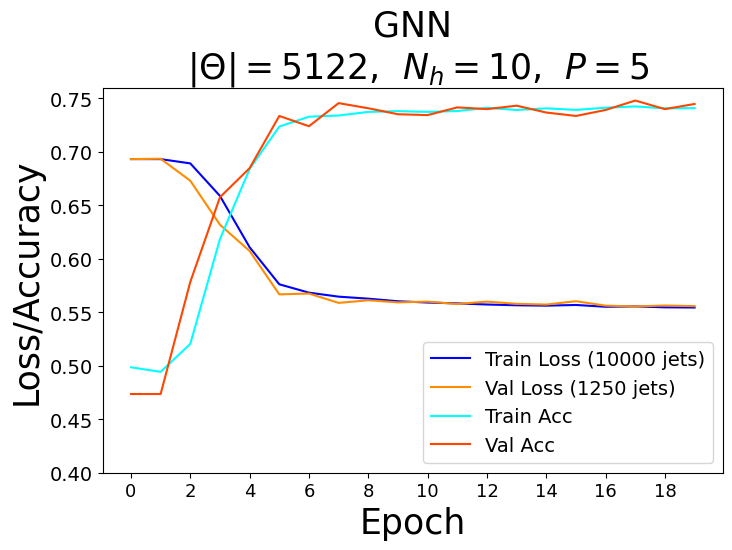

In [ ]:
# Plot the training accuracy
fig = plt.figure(figsize=(8,5))
plt.plot(gnn_model_and_history['history']['train_loss'],c='b',label=f'Train Loss ({train_index} jets)')
plt.plot(gnn_model_and_history['history']['val_loss'],c='darkorange',label=f'Val Loss ({val_index-train_index} jets)')
plt.plot(gnn_model_and_history['history']['train_accuracy'],c='cyan',label='Train Acc')
plt.plot(gnn_model_and_history['history']['val_accuracy'],c='orangered',label='Val Acc')
plt.title(f'GNN\n $|\Theta| = {count_theta_gnn}$,  $N_h={nf_gnn}$,  $P={n_layers_gnn}$', fontsize=25)
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss/Accuracy',fontsize=25)
plt.legend(fontsize = 14, loc = 'lower right')
plt.xticks(fontsize=13,ticks=[i for i in range(0,epochs,2)])
plt.yticks(fontsize=14)
plt.ylim([0.40,0.76])
plt.savefig(plot_path+f'gnn_training_{count_theta_gnn}_{nf_gnn}_{n_layers_gnn}_{seed_gnn}.png',bbox_inches='tight')

In [ ]:
model = copy.deepcopy(gnn_model_and_history['model'])
model.eval()
with torch.no_grad():
    labels_all = None
    for i,data in enumerate(test_dataloader):
        node_size = (data.batch==0).sum()
        batch_size = data.x.shape[0]
        node_size, n_nodes = data[0].x.size()

        edge_index = data.edge_index.to(device)
        edge_attr = data.edge_attr.to(device)
        labels = data.y.double().reshape(batch_size//node_size,).cpu()

        edges = [edge_index[0,:].to(device), edge_index[1,:].to(device)]
        node_features = torch.stack([data.x[:,1],
                                     data.x[:,2],
                                     data.x[:,0],
                                     data.x[:,3],
                                     data.x[:,4],
                                     data.x[:,5],
                                     data.x[:,6],
                                     data.x[:,7] ], dim=1).to(device)

        labels_pred = model(node_features, edges, edge_attr).cpu()

        if labels_all is not None:
            labels_all = torch.cat([labels_all,labels],dim=0)
            labels_pred_all = torch.cat([labels_pred_all,labels_pred],dim=0)
        else:
            labels_all = copy.deepcopy(labels)
            labels_pred_all = copy.deepcopy(labels_pred)

In [ ]:
# labels_all

In [ ]:
# labels_pred_all

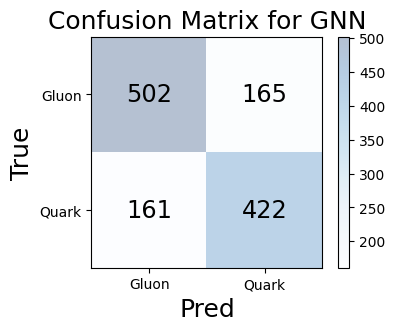

Accuracy for GNN:  tensor(0.7392)


In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=labels_all, y_pred=labels_pred_all.argmax(dim=1))
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Pred', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix for GNN', fontsize=18)
plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.colorbar(im)
plt.show()

size=labels_all.shape[0]
num_correct = (labels_all==labels_pred_all.argmax(dim=1)).sum().int()
print('Accuracy for GNN: ',num_correct/size)

In [ ]:
labels_pred_all.max(dim=1)[0]

tensor([0.9997, 0.6085, 1.0000,  ..., 0.6951, 0.9929, 1.0000])

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
first_idx = torch.arange(0,labels_pred_all.shape[0])
y_score_gnn = labels_pred_all[(first_idx,labels_all.int())]
fpr_gnn, tpr_gnn, thresholds = roc_curve(labels_all, y_score_gnn)
auc_score_gnn = roc_auc_score(labels_all, y_score_gnn)

In [ ]:
np.save(plot_path+f'fpr_gnn_{count_theta_gnn}_{nf_gnn}_{n_layers_gnn}_{seed_gnn}.npy',fpr_gnn)
np.save(plot_path+f'tpr_gnn_{count_theta_gnn}_{nf_gnn}_{n_layers_gnn}_{seed_gnn}.npy',tpr_gnn)
np.save(plot_path+f'y_score_gnn_{count_theta_gnn}_{nf_gnn}_{n_layers_gnn}_{seed_gnn}.npy',y_score_gnn)
np.save(plot_path+f'labels_all_gnn_{count_theta_gnn}_{nf_gnn}_{n_layers_gnn}_{seed_gnn}.npy',labels_all.numpy())

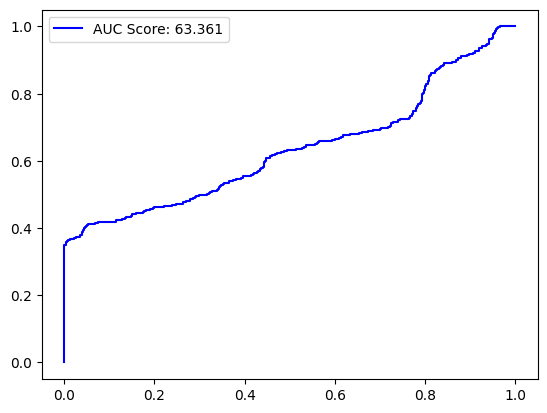

In [ ]:
plt.plot(fpr_gnn,tpr_gnn,label = f'AUC Score: {100*auc_score_gnn:.3f}',c='b')
plt.legend()

# Equivariant GNN (EGNN)

## EGNN Layers

In [ ]:
class EGCL(nn.Module):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_att_dim=0, act_fn=nn.ReLU(), recurrent=True, coords_weight=1.0, attention=False, clamp=False, norm_diff=False, tanh=False):
        super(EGCL, self).__init__()
        input_edge = input_nf * 2 # hi + hj dim = num_features*2
        self.coords_weight = coords_weight
        self.recurrent = recurrent
        self.attention = attention
        self.norm_diff = norm_diff
        self.tanh = tanh
        edge_coords_nf = 1 # |xi-xj| dim =1


        self.edge_mlp = nn.Sequential( nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
                                      act_fn,
                                      nn.Linear(hidden_nf, hidden_nf),
                                      act_fn,
                                      nn.Linear(hidden_nf, hidden_nf),
                                      act_fn)

        self.node_mlp = nn.Sequential( nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
                                       act_fn,
                                       nn.Linear(hidden_nf, output_nf),
                                       act_fn,
                                       nn.Linear(hidden_nf, output_nf))

        self.edge_x_mlp = nn.Sequential( nn.Linear(hidden_nf, hidden_nf),
                                           act_fn,
                                            nn.Linear(hidden_nf, hidden_nf),
                                           act_fn,
                                           nn.Linear(hidden_nf, 1, bias = False))

        self.clamp = clamp

        if self.attention:
            self.att_mlp = nn.Sequential(nn.Linear(hidden_nf, 1),
                                         nn.Sigmoid())


    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1) #hi,hj, |x_i-x_j|
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1) #hi,hj, |x_i-x_j|, a_ij
        m_ij = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(m_ij)
            m_ij = m_ij * att_val
        return m_ij

    def node_model(self, h, edge_index, edge_attr, node_attr):
        row, col = edge_index
        size = int(edge_attr.shape[0]/h.shape[0])
        aggregate = nn.AvgPool1d(kernel_size=size, stride=size)
        if node_attr is not None:
            agg = torch.cat([h, aggregate(edge_attr.T).T, node_attr], dim=1)
        else:
            agg = torch.cat([h, aggregate(edge_attr.T).T], dim=1)  # h_i, m_i

        hi_lplus1 = self.node_mlp(agg)
        # if self.recurrent:
        #     hi_lplus1 = h + hi_lplus1
        return hi_lplus1, agg

    def coord_norm(self, edge_index, coordinates):
        row, col = edge_index
        coord_direction = coordinates[row] - coordinates[col]
        radial = torch.sum((coord_direction)**2, dim = 1).unsqueeze(1)

        if self.norm_diff:
            norm = torch.sqrt(radial) # + 1
            coord_direction = coord_direction/norm

        return radial, coord_direction

    def equi_coordinate(self, coordinates, edge_index, m_ij):
        row, col = edge_index
        equi_coordinates = - (coordinates[row] - coordinates[col])/np.log(row.shape[0])*self.edge_x_mlp(m_ij)  #self.coord_mlp(m_ij)
        size = int(len(row)/coordinates.shape[0])       # = nodes_per_graph-1, i.e. # of distinct neighbors
                                                        # = batch_size*nodes_per_graph*(nodes_per_graph-1, i.e. # of distinct neighbors) / (batch_size*nodes_per_graph)
        aggregate = nn.AvgPool1d(kernel_size=size, stride=size) # size = 2 here for nodes_per_graph = 3
        xi_lplus1 = coordinates+aggregate(equi_coordinates.T).T
        return xi_lplus1

    def forward(self, h, edge_index, coordinates, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_direction = self.coord_norm(edge_index, coordinates)  # returns radial distance and direction between points
        m_ij = self.edge_model(h[row], h[col], radial, edge_attr)
        coordinates = self.equi_coordinate(coordinates, edge_index, m_ij)
        h, agg = self.node_model(h, edge_index, m_ij, node_attr)

        return h, coordinates, edge_attr

## EGNN Model

In [ ]:
class EGNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.LeakyReLU(0.2), n_layers=4, kernel_size = None, coords_weight=1.0):
        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers

        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)

        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, EGCL(input_nf = self.hidden_nf,
                                               output_nf = self.hidden_nf,
                                               hidden_nf = self.hidden_nf,
                                               edges_in_d=in_edge_nf,
                                               act_fn=act_fn,
                                               recurrent=True,
                                               coords_weight=coords_weight,
                                               norm_diff = True))

        self.mean_pool = nn.AvgPool1d(kernel_size=kernel_size, stride=kernel_size)
        self.coord_dim = 2

        self.decoder = nn.Sequential( nn.Linear(self.hidden_nf, 2*self.hidden_nf),
                                      act_fn,
                                      nn.Linear(2*self.hidden_nf, 2*self.hidden_nf),
                                      act_fn,
                                      nn.Linear(2*self.hidden_nf, 2) )
        self.to(self.device)


    def forward(self, h, x, edge_index, edge_attr):
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, x, _ = self._modules["gcl_%d" % i](h, edge_index, x, edge_attr=edge_attr)

        h = self.mean_pool(h.T).T
        h = self.decoder(h)

        return nn.Softmax(dim=1)(h)

In [ ]:
seed_egnn = 2
torch.manual_seed(seed_egnn)
nf_egnn = 10
n_layers_egnn = 4
kernel_size =x_data_proc.shape[1]
in_node_nf= x_data_proc.shape[2]
model_key = 'EGNN'
model = EGNN(in_node_nf=in_node_nf,
             in_edge_nf=2,
             hidden_nf=nf_egnn,
             n_layers=n_layers_egnn,
             kernel_size = kernel_size,
             device=device)
lr = 1e-3
wd = 1e-12
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=wd)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
count_theta_egnn = 0
for i,param in enumerate(model.parameters()):
    count_theta_egnn+=param.flatten().shape[0]

In [ ]:
print(count_theta_egnn)

5252


In [ ]:
epochs = 20

egnn_model_and_history = training(model = model,
                             epochs = epochs,
                             loader_train = train_dataloader,
                             loader_val  = val_dataloader,
                             loader_test = test_dataloader)

  5%|▌         | 1/20 [00:03<01:04,  3.41s/it]



Epoch: 0 |  Best Train Loss: 0.69335243 | Best Val Loss: 0.69362444 | Best Train Acc: 0.49240000 | Best Val Acc: 0.47360000
Epoch: 0 |  VAL AUC: 0.00000000 



 10%|█         | 2/20 [00:06<01:02,  3.45s/it]



Epoch: 1 |  Best Train Loss: 0.69325821 | Best Val Loss: 0.69362334 | Best Train Acc: 0.49880000 | Best Val Acc: 0.47360000
Epoch: 1 |  VAL AUC: 0.00000000 



 15%|█▌        | 3/20 [00:10<00:59,  3.50s/it]



Epoch: 2 |  Best Train Loss: 0.68542606 | Best Val Loss: 0.64206893 | Best Train Acc: 0.54310000 | Best Val Acc: 0.65360000
Epoch: 2 |  VAL AUC: 0.44582786 



 20%|██        | 4/20 [00:13<00:55,  3.46s/it]



Epoch: 3 |  Best Train Loss: 0.61535607 | Best Val Loss: 0.57366395 | Best Train Acc: 0.67640000 | Best Val Acc: 0.72960000
Epoch: 3 |  VAL AUC: 0.54009642 



 25%|██▌       | 5/20 [00:17<00:51,  3.44s/it]



Epoch: 4 |  Best Train Loss: 0.57208829 | Best Val Loss: 0.56474921 | Best Train Acc: 0.73030000 | Best Val Acc: 0.73520000
Epoch: 4 |  VAL AUC: 0.63385669 



 30%|███       | 6/20 [00:21<00:49,  3.56s/it]



Epoch: 5 |  Best Train Loss: 0.57208829 | Best Val Loss: 0.56474921 | Best Train Acc: 0.73030000 | Best Val Acc: 0.73520000
Epoch: 5 |  VAL AUC: 0.35552298 



 35%|███▌      | 7/20 [00:24<00:46,  3.61s/it]



Epoch: 6 |  Best Train Loss: 0.56100484 | Best Val Loss: 0.56041363 | Best Train Acc: 0.73990000 | Best Val Acc: 0.73840000
Epoch: 6 |  VAL AUC: 0.49621344 



 40%|████      | 8/20 [00:28<00:43,  3.59s/it]



Epoch: 7 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 7 |  VAL AUC: 0.45050008 



 45%|████▌     | 9/20 [00:32<00:39,  3.63s/it]



Epoch: 8 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 8 |  VAL AUC: 0.35213947 



 50%|█████     | 10/20 [00:36<00:38,  3.83s/it]



Epoch: 9 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 9 |  VAL AUC: 0.60634961 



 55%|█████▌    | 11/20 [00:39<00:33,  3.77s/it]



Epoch: 10 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 10 |  VAL AUC: 0.49215990 



 60%|██████    | 12/20 [00:43<00:30,  3.76s/it]



Epoch: 11 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 11 |  VAL AUC: 0.29293827 



 65%|██████▌   | 13/20 [00:47<00:26,  3.75s/it]



Epoch: 12 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 12 |  VAL AUC: 0.59716175 



 70%|███████   | 14/20 [00:51<00:22,  3.82s/it]



Epoch: 13 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 13 |  VAL AUC: 0.37424526 



 75%|███████▌  | 15/20 [00:55<00:19,  3.83s/it]



Epoch: 14 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 14 |  VAL AUC: 0.56558316 



 80%|████████  | 16/20 [00:58<00:15,  3.75s/it]



Classical Indicator: Saving model weights at epoch 15 to attain the best classifier.
Epoch: 15 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 15 |  VAL AUC: 0.49199561 



 85%|████████▌ | 17/20 [01:02<00:11,  3.84s/it]



Epoch: 16 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 16 |  VAL AUC: 0.35642662 



 90%|█████████ | 18/20 [01:06<00:07,  3.80s/it]



Classical Indicator: Saving model weights at epoch 17 to attain the best classifier.
Epoch: 17 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 17 |  VAL AUC: 0.68260443 



 95%|█████████▌| 19/20 [01:10<00:03,  3.72s/it]



Epoch: 18 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 18 |  VAL AUC: 0.54256859 



100%|██████████| 20/20 [01:13<00:00,  3.67s/it]



Epoch: 19 |  Best Train Loss: 0.56108230 | Best Val Loss: 0.56000258 | Best Train Acc: 0.73660000 | Best Val Acc: 0.74080000
Epoch: 19 |  VAL AUC: 0.61982461 

-------------------------------------------------------

 Total Time: 73.47196865
Training Complete.


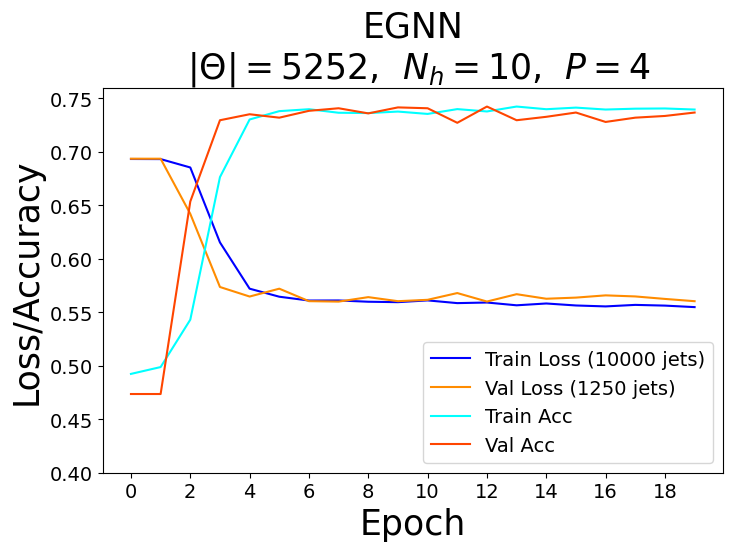

In [ ]:
# Plot the training accuracy
fig = plt.figure(figsize=(8,5))
plt.plot(egnn_model_and_history['history']['train_loss'],c='b',label=f'Train Loss ({train_index} jets)')
plt.plot(egnn_model_and_history['history']['val_loss'],c='darkorange',label=f'Val Loss ({val_index-train_index} jets)')
plt.plot(egnn_model_and_history['history']['train_accuracy'],c='cyan',label='Train Acc')
plt.plot(egnn_model_and_history['history']['val_accuracy'],c='orangered',label='Val Acc')
plt.title(f'EGNN\n $|\Theta| = {count_theta_egnn}$,  $N_h={nf_egnn}$,  $P={n_layers_egnn}$', fontsize=25)
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss/Accuracy',fontsize=25)
plt.legend(fontsize = 14,loc = 'lower right')
plt.xticks(fontsize=13,ticks=[i for i in range(0,epochs,2)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.40,0.76])
plt.savefig(plot_path+f'egnn_training_{count_theta_egnn}_{nf_egnn}_{n_layers_egnn}_{seed_egnn}.png',bbox_inches='tight')

In [ ]:
model = copy.deepcopy(egnn_model_and_history['model'])
model.eval()
with torch.no_grad():
    labels_all = None
    for i,data in enumerate(test_dataloader):
        node_size = (data.batch==0).sum()
        batch_size = data.x.shape[0]
        node_size, n_nodes = data[0].x.size()

        edge_index = data.edge_index.to(device)
        edge_attr = data.edge_attr.to(device)
        labels = data.y.double().reshape(batch_size//node_size,).cpu()


        edge_inds = [edge_index[0,:].to(device), edge_index[1,:].to(device)]

        optimizer.zero_grad()

        locations = torch.stack([data.x[:,1],
                                 data.x[:,2]  ], dim=1).to(device)

        node_features = torch.stack([data.x[:,1],
                                     data.x[:,2],
                                     data.x[:,0],
                                     data.x[:,3],
                                     data.x[:,4],
                                     data.x[:,5],
                                     data.x[:,6],
                                     data.x[:,7] ], dim=1).to(device)

        rows, cols = edge_inds
        locations_dist = torch.sum( (locations[rows] - locations[cols])**2, dim=1).unsqueeze(1)  # relative distances among locations

        edge_attr = torch.cat([ edge_attr, locations_dist ], dim=1).detach()  # concatenate all edge properties
        labels_pred = model(node_features, locations, edge_inds, edge_attr).cpu()

        if labels_all is not None:
            labels_all = torch.cat([labels_all,labels],dim=0)
            labels_pred_all = torch.cat([labels_pred_all,labels_pred],dim=0)
        else:
            labels_all = copy.deepcopy(labels)
            labels_pred_all = copy.deepcopy(labels_pred)

In [ ]:
# labels_all

In [ ]:
# labels_pred_all

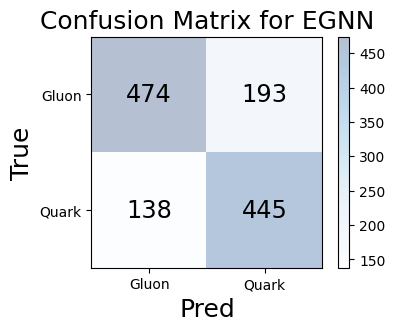

Accuracy for EGNN:  tensor(0.7352)


In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=labels_all, y_pred=labels_pred_all.argmax(dim=1))
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Pred', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix for EGNN', fontsize=18)
plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.colorbar(im)
plt.show()

size=labels_all.shape[0]
num_correct = (labels_all==labels_pred_all.argmax(dim=1)).sum().int()
print('Accuracy for EGNN: ',num_correct/size)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
first_idx = torch.arange(0,labels_pred_all.shape[0])
y_score_egnn = labels_pred_all[(first_idx,labels_all.int())]
fpr_egnn, tpr_egnn, thresholds_egnn = roc_curve(labels_all, y_score_egnn)
auc_score_egnn = roc_auc_score(labels_all, y_score_egnn)

In [ ]:
np.save(plot_path+f'fpr_egnn_{count_theta_egnn}_{nf_egnn}_{n_layers_egnn}_{seed_egnn}.npy',fpr_egnn)
np.save(plot_path+f'tpr_egnn_{count_theta_egnn}_{nf_egnn}_{n_layers_egnn}_{seed_egnn}.npy',tpr_egnn)
np.save(plot_path+f'y_score_egnn_{count_theta_egnn}_{nf_egnn}_{n_layers_egnn}_{seed_egnn}.npy',y_score_egnn)
np.save(plot_path+f'labels_all_egnn_{count_theta_egnn}_{nf_egnn}_{n_layers_egnn}_{seed_egnn}.npy',labels_all.numpy())

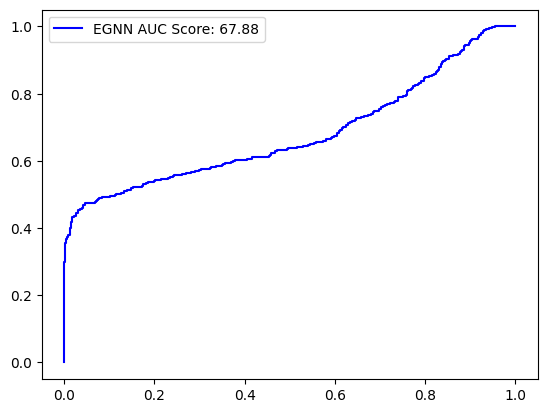

In [ ]:
plt.plot(fpr_egnn,tpr_egnn,label = f'EGNN AUC Score: {100*auc_score_egnn:.2f}',c='b')
plt.legend()